## A. 전처리

### 1. 데이터 불러오기

In [42]:
import pandas as pd
import numpy as np

data = pd.read_csv('./data/lending_club_2020_train.csv')

### 2. feature selection

In [43]:
# 수익률 계산 컬럼 리스트
# term, installment, total_pymnt, recoveries

In [44]:
# 학습에 사용할 피처 리스트
train_features = [
    'id', 'hardship_flag', 'debt_settlement_flag', 'loan_status_binary', 'loan_status',
    'loan_amnt', 'int_rate', 'installment', 'grade', 'annual_inc', 'dti', 'delinq_2yrs',
    'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'revol_util', 'total_acc',
    'last_fico_range_high', 'collections_12_mths_ex_med', 'mths_since_last_major_derog',
    'tot_coll_amt', 'mths_since_rcnt_il', 'total_rev_hi_lim', 'acc_open_past_24mths',
    'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
    'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
    'num_il_tl', 'num_op_rev_tl', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
    'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort',
    'total_bc_limit', 'total_il_high_credit_limit', 'home_ownership', 'verification_status',
    'purpose', 'title', 'addr_state', 'initial_list_status'
]

cols_to_drop = [col for col in data.columns if col not in train_features]
data.drop(columns=cols_to_drop, inplace=True)

### 3. 결측치 처리

#### 타겟 변수 설정

In [45]:
# Current = X
# Fully Paid = 1
# Charged Off = 0
# Late (31-120 days) = X
# In Grace Period = X
# Late (16-30 days) = X
# Issued = X
# Default = 0

# loan_status를 0과 1로 변환
data['loan_status_binary'] = data['loan_status'].apply(lambda x: 
    1 if x == 'Fully Paid' else 
    0 if x in ['Charged Off', 'Default']
    else None)

data = data.dropna(subset=['loan_status_binary'])
data.drop(columns=['loan_status'], inplace=True)

In [46]:
# small version
data = data.sample(frac=0.05, random_state=42).reset_index(drop=True)

# data.to_csv('./data/lending_club_2020_train_small_original.csv', index = False)

#### null 처리

In [47]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columns_to_encode = [
    'mths_since_last_delinq', 'mths_since_recent_revol_delinq', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'mths_since_last_record',
    'mths_since_recent_inq', 'mo_sin_old_il_acct', 'mths_since_rcnt_il', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq'
]

for col in columns_to_encode:
    if col in data.columns:
        mean_value = data[col][data[col] > 0].mean()
        
        data[col] = data[col].apply(lambda x: 
            1 if pd.notna(x) and x > mean_value else 
            2 if pd.notna(x) and x > 0 else 
            0)
        
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

data.dropna(inplace=True)

### 4. 스케일링

In [48]:
data['revol_util'] = data['revol_util'].str.replace('%', '').astype(float) / 100
data['int_rate'] = data['int_rate'].str.replace('%', '').astype(float) / 100

log_columns = ['dti', 'revol_util', 'annual_inc']

for col in log_columns:
    if col in data.columns:
        data[col] = np.log1p(data[col])

### 5. 수치형 데이터로 변환 (레이블인코딩, 원핫인코딩)

In [49]:
from datetime import datetime

data['id'] = pd.to_numeric(data['id'], errors='coerce').astype('Int64')

In [50]:
# 레이블 인코딩 적용할 컬럼 정의
# term, sub_grade

# 원-핫 인코딩 적용할 컬럼 정의
# home_ownership, verification_status, pymnt_plan, purpose, title, addr_state
# initial_list_status, application_type

# Y, N를 1과 0으로 정의
# hardship_flag, debt_settlement_flag

In [51]:
# 레이블 인코딩 적용할 컬럼 정의
label_enc_cols = ['grade']
label_encoders = {}

for col in label_enc_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 원-핫 인코딩 적용할 컬럼 정의
one_hot_cols = [
    'home_ownership', 'verification_status', 'purpose', 'title',
    'addr_state', 'initial_list_status'
]

# 'hardship_flag'와 'debt_settlement_flag'를 Y=1, N=0으로 변환 (NaN은 1로 처리)
binary_cols = ['hardship_flag', 'debt_settlement_flag']
for col in binary_cols:
    data[col] = data[col].map({'Y': 1, 'N': 0}).fillna(1).astype(int)

# OneHotEncoder 적용
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
ohe_data = ohe.fit_transform(data[one_hot_cols])

ohe_df = pd.DataFrame.sparse.from_spmatrix(ohe_data, index=data.index)
ohe_df.columns = ohe.get_feature_names_out(one_hot_cols)
data = pd.concat([data.drop(columns=one_hot_cols), ohe_df], axis=1)

### 6. 피처엔지니어링: after data 예측

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.combine import SMOTEENN

from pycaret.classification import *
from sklearn.metrics import accuracy_score

#### hardship_flag

In [53]:
# train, test set 분할
X = data.drop(['hardship_flag', 'loan_status_binary', 'debt_settlement_flag'], axis=1)
y = data['hardship_flag']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12
)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# 스케일링
normal_col = ['annual_inc', 'loan_amnt', 'int_rate', 'dti', 'installment', 'revol_util']

scaler_normal = StandardScaler()

x_train[normal_col] = scaler_normal.fit_transform(x_train[normal_col])
x_test[normal_col] = scaler_normal.transform(x_test[normal_col])

In [54]:
train_resampled = pd.DataFrame(x_train, columns=x_train.columns)
train_resampled['hardship_flag'] = y_train

# 모델 설정
model = setup(
    data=train_resampled,
    target='hardship_flag',
    session_id=123,
    preprocess=False,      
    fix_imbalance=False,   
    normalize=False,    
)

,Description,Value
0,Session id,123
1,Target,hardship_flag
2,Target type,Binary
3,Original data shape,"(41723, 2167)"
4,Transformed data shape,"(41723, 2167)"
5,Transformed train set shape,"(29206, 2167)"
6,Transformed test set shape,"(12517, 2167)"
7,Numeric features,2166


In [14]:
# model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9989,0.4971,0.0000,0.0000,0.0000,0.0000,0.0000,5.9080
svm,SVM - Linear Kernel,0.9989,0.1368,0.0000,0.0000,0.0000,0.0000,0.0000,1.7230
ridge,Ridge Classifier,0.9989,0.7687,0.0000,0.0000,0.0000,0.0000,0.0000,0.8520
rf,Random Forest Classifier,0.9989,0.5860,0.0000,0.0000,0.0000,0.0000,0.0000,0.8790
ada,Ada Boost Classifier,0.9989,0.7172,0.0000,0.0000,0.0000,-0.0001,-0.0001,2.4470
et,Extra Trees Classifier,0.9989,0.4853,0.0000,0.0000,0.0000,0.0000,0.0000,1.3440
dummy,Dummy Classifier,0.9989,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4420
lr,Logistic Regression,0.9988,0.5338,0.0000,0.0000,0.0000,-0.0001,-0.0001,13.9570
nb,Naive Bayes,0.9979,0.7439,0.0000,0.0000,0.0000,-0.0009,-0.0010,0.6550
gbc,Gradient Boosting Classifier,0.9978,0.7049,0.0333,0.0143,0.0200,0.0190,0.0208,7.8200


In [57]:
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9990,0.6194,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9990,0.4584,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9990,0.4577,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9990,0.4512,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9986,0.5839,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9986,0.4570,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9990,0.4568,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9990,0.4556,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9990,0.4542,0.0000,0.0000,0.0000,0.0000,0.0000


In [58]:
test_for_pycaret = x_test.copy()
test_for_pycaret['hardship_flag'] = y_test

predictions_prob = predict_model(model, data=test_for_pycaret, raw_score=True)

# 예측 확률(Score_1)과 실제 타깃
y_true = predictions_prob['hardship_flag']
y_prob = predictions_prob['prediction_score_1']

best_threshold = 0.5
best_accuracy = 0.0

for threshold in np.linspace(0.0, 1.0, 101):
    # 확률이 threshold 이상이면 1로 예측
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}, Accuracy: {best_accuracy:.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9988,0.5366,0.0000,0.0000,0.0000,0.0000,0.0000


Best threshold: 0.08, Accuracy: 0.9988


In [59]:
data['hardship_flag_predict_score'] = predictions_prob['prediction_score_1']

data['hardship_flag_predict'] = (data['hardship_flag_predict_score'] >= best_threshold).astype(int)

data.drop(columns=['hardship_flag'], inplace=True)

#### debt_settlement_flag

In [60]:
# train, test set 분할
X = data.drop(['debt_settlement_flag', 'loan_status_binary', 'debt_settlement_flag'], axis=1)
y = data['debt_settlement_flag']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12
)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# 스케일링
normal_col = ['annual_inc', 'loan_amnt', 'int_rate', 'dti', 'installment', 'revol_util']

scaler_normal = StandardScaler()

x_train[normal_col] = scaler_normal.fit_transform(x_train[normal_col])
x_test[normal_col] = scaler_normal.transform(x_test[normal_col])

In [61]:
train_resampled = pd.DataFrame(x_train, columns=x_train.columns)
train_resampled['debt_settlement_flag'] = y_train

# 모델 설정
model = setup(
    data=train_resampled,
    target='debt_settlement_flag',
    session_id=123,
    preprocess=False,      
    fix_imbalance=False,   
    normalize=False,    
)

,Description,Value
0,Session id,123
1,Target,debt_settlement_flag
2,Target type,Binary
3,Original data shape,"(41723, 2169)"
4,Transformed data shape,"(41723, 2169)"
5,Transformed train set shape,"(29206, 2169)"
6,Transformed test set shape,"(12517, 2169)"
7,Numeric features,2168
8,Rows with missing values,100.0%


In [138]:
model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9727,0.7341,0.0000,0.0000,0.0000,0.0000,0.0000,1.7560
dummy,Dummy Classifier,0.9727,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4260
lightgbm,Light Gradient Boosting Machine,0.9721,0.8631,0.0113,0.2233,0.0214,0.0191,0.0444,0.6340
dt,Decision Tree Classifier,0.9449,0.5369,0.1053,0.0855,0.0943,0.0662,0.0666,0.6940


In [62]:
model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9726,0.7344,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9726,0.7216,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9726,0.7350,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9726,0.7106,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9726,0.7345,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9726,0.7402,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9729,0.7325,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9729,0.7715,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9729,0.7355,0.0000,0.0000,0.0000,0.0000,0.0000


In [63]:
test_for_pycaret = x_test.copy()
test_for_pycaret['debt_settlement_flag'] = y_test

predictions_prob = predict_model(model, data=test_for_pycaret, raw_score=True)

# 예측 확률(Score_1)과 실제 타깃
y_true = predictions_prob['debt_settlement_flag']
y_prob = predictions_prob['prediction_score_1']

best_threshold = 0.5
best_accuracy = 0.0

for threshold in np.linspace(0.0, 1.0, 101):
    # 확률이 threshold 이상이면 1로 예측
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}, Accuracy: {best_accuracy:.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9686,0.7755,0.0000,0.0000,0.0000,0.0000,0.0000


Best threshold: 0.20, Accuracy: 0.9686


In [64]:
data['debt_settlement_flag_predict_score'] = predictions_prob['prediction_score_1']

data['debt_settlement_flag_predict'] = (data['debt_settlement_flag_predict_score'] >= best_threshold).astype(int)

data.drop(columns=['debt_settlement_flag'], inplace=True)

### 8. 데이터 분할

In [65]:
X = data.drop(['loan_status_binary'], axis=1)
y = data['loan_status_binary']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=12)

### 9. 정규화

In [66]:
# 스케일링
normal_col = ['annual_inc', 'loan_amnt', 'int_rate', 'dti', 'installment', 'revol_util']

scaler_normal = StandardScaler()

x_train[normal_col] = scaler_normal.fit_transform(x_train[normal_col])
x_test[normal_col] = scaler_normal.transform(x_test[normal_col])

## B. 모델

### 1. pycaret

In [67]:
import shap
from pycaret.classification import *
import matplotlib.pyplot as plt

model = setup(data=data, target='loan_status_binary', session_id=123)

,Description,Value
0,Session id,123
1,Target,loan_status_binary
2,Target type,Binary
3,Original data shape,"(52154, 2171)"
4,Transformed data shape,"(52154, 2171)"
5,Transformed train set shape,"(36507, 2171)"
6,Transformed test set shape,"(15647, 2171)"
7,Numeric features,2170
8,Rows with missing values,80.0%
9,Preprocess,True


In [73]:
model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9088,0.9478,0.9417,0.9446,0.9431,0.7130,0.7130
1,0.8959,0.9419,0.9335,0.9367,0.9351,0.6727,0.6727
2,0.9006,0.9431,0.9382,0.9379,0.9381,0.6858,0.6858
3,0.8965,0.9442,0.9386,0.9329,0.9357,0.6699,0.6700
4,0.9080,0.9497,0.9444,0.9412,0.9428,0.7078,0.7078
5,0.8984,0.9423,0.9362,0.9372,0.9367,0.6796,0.6796
6,0.8995,0.9486,0.9342,0.9402,0.9372,0.6857,0.6858
7,0.8967,0.9393,0.9379,0.9338,0.9358,0.6713,0.6713
8,0.9071,0.9534,0.9440,0.9405,0.9423,0.7047,0.7048


In [75]:
test_for_pycaret = x_test.copy()
test_for_pycaret['loan_status_binary'] = y_test

predictions_prob = predict_model(model, data=data, raw_score=True)

# 예측 확률(Score_1)과 실제 타깃
y_true = predictions_prob['loan_status_binary']
y_prob = predictions_prob['prediction_score_1']

best_threshold = 0.5
best_accuracy = 0.0

for threshold in np.linspace(0.0, 1.0, 101):
    # 확률이 threshold 이상이면 1로 예측
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}, Accuracy: {best_accuracy:.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9052,0.9501,0.9407,0.9412,0.9410,0.7007,0.7007


Best threshold: 0.48, Accuracy: 0.9055


In [77]:
data['predict_score'] = predictions_prob['prediction_score_1']

data['predicted_y'] = (data['predict_score'] >= best_threshold).astype(int)

data.drop(columns=['predict_score'], inplace=True)

In [194]:
save_model(model, 'model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['id', 'loan_amnt', 'int_rate',
                                              'installment', 'grade',
                                              'annual_inc', 'dti', 'delinq_2yrs',
                                              'inq_last_6mths',
                                              'mths_since_last_record',
                                              'open_acc', 'revol_util',
                                              'total_acc',
                                              'last_fico_range_high',
                                              'collections_12_mths_ex_med',
                                              'mths_since_last_major_derog',...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, lo

#### feature important

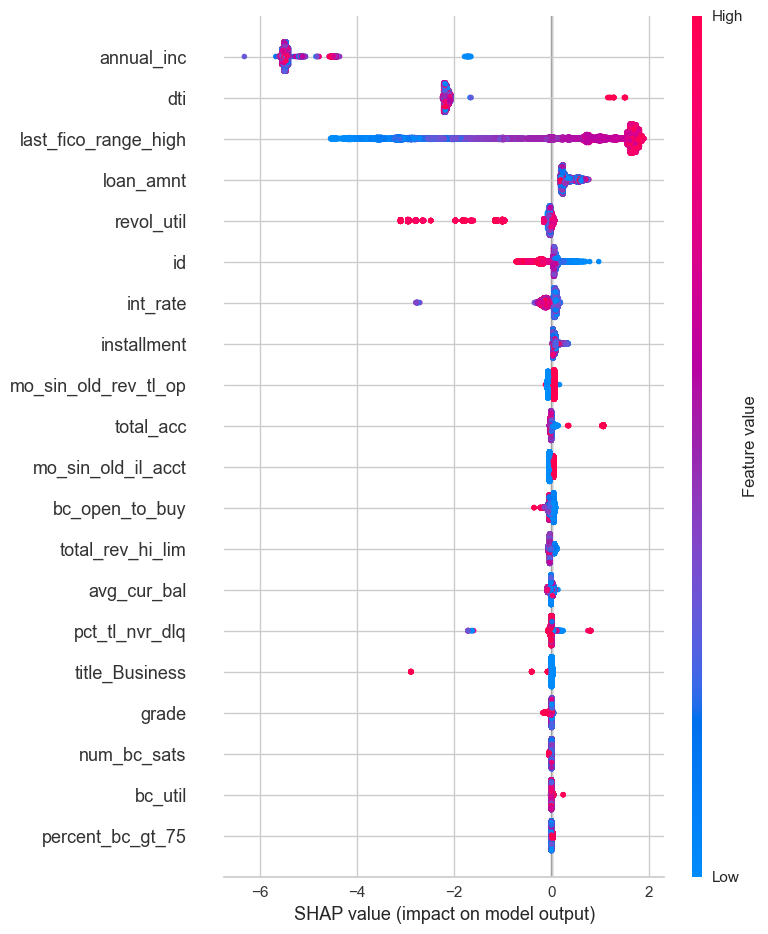

In [78]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)

In [180]:
# shap.summary_plot(shap_values[1], x_test, plot_type="dot")

In [181]:
data.to_csv('./data/lending_club_2020_train_predict_y.csv', index = False)

#### id 합치기

In [79]:
data1 = pd.read_csv('./data/lending_club_2020_train.csv')

data1 = data1.sample(frac=0.05, random_state=42).reset_index(drop=True)

In [80]:
data1['id'] = pd.to_numeric(data1['id'], errors='coerce').astype('Int64')
data['id'] = pd.to_numeric(data['id'], errors='coerce').astype('Int64')

data.set_index('id', inplace=True)
common_ids = data1['id'].isin(data.index)
data1.loc[common_ids, 'predicted_y'] = data.loc[data1.loc[common_ids, 'id'], 'predicted_y'].values

In [81]:
data1.to_csv('./data/lending_club_2020_train_predict_yy.csv', index = False)

## C. 수익률 계산

In [82]:
df = pd.read_csv("./data/lending_club_2020_train_predict_yy.csv")

df = df[df['predicted_y'].notna()]

### 만기 36개월과 60개월을 나누기

In [83]:
# term 컬럼 값에 혹시 공백이 있다면 제거(필요할 경우)
df['term'] = df['term'].str.strip()  # 예: ' 36 months' -> '36 months'

# term이 '36 months'인 행만 추출하고 term 컬럼은 드롭
df_36 = df[df['term'] == '36 months'].drop('term', axis=1)

# term이 '60 months'인 행만 추출하고 term 컬럼은 드롭
df_60 = df[df['term'] == '60 months'].drop('term', axis=1)

statuses_to_keep = ['Fully Paid', 'Charged Off', 'Default']
df_36 = df_36[df_36['loan_status'].isin(statuses_to_keep)]
df_60 = df_60[df_60['loan_status'].isin(statuses_to_keep)]

### 개별 만기에 대한 수익률 구하기

In [84]:
import numpy_financial as npf
import pandas as pd

def calculate_actual_irr(row, n_months):
    """
    대출 상태에 따라 실제 IRR(연환산)을 계산합니다.
    
    - Fully Paid:
        현금흐름 = [-loan_amnt, installment, installment, ..., installment] (총 n_months회 지급)
    - Charged Off / Default:
        지급 횟수 p를 정기 상환금과 총 지급액으로 근사:
            p ≈ total_pymnt / installment
        현금흐름:
            초기: -loan_amnt
            중간: installment가 p-1회 지급
            마지막: installment와 recoveries(회수액)가 합산되어 지급
        
    매개변수:
        row: DataFrame의 한 행 (대출 정보)
        n_months: 대출 만기 (예: 36 또는 60)
    
    반환:
        연환산 IRR (float) 또는 계산 불가 시 None
    """
    loan_amnt = row['loan_amnt']
    status = row['loan_status']
    
    if status == 'Fully Paid':
        # Fully Paid: 예정된 만기 동안 매월 동일한 installment 지급
        cash_flows = [-loan_amnt] + [row['installment']] * n_months
        monthly_irr = npf.irr(cash_flows)
        if monthly_irr is None or not isinstance(monthly_irr, (int, float)):
            return None
        return (1 + monthly_irr)**12 - 1
    
    elif status in ['Charged Off', 'Default']:
        # 지급 횟수 p를 total_pymnt와 installment로 근사
        installment = row['installment']
        total_pymnt = row['total_pymnt']
        if installment and installment != 0:
            # p가 소수점이 나올 수 있으므로 반올림 후 정수화
            p = int(round(total_pymnt / installment))
            p = max(p, 1)  # 최소 1회 이상 지급되었음을 보장
        else:
            p = int(n_months / 2)  # fallback
        
        # 현금흐름 구성:
        # 초기 현금흐름: 대출금 상환 (-loan_amnt)
        # 이후 p-1회는 installment 지급, 마지막 회차에는 installment와 recoveries 추가
        if p == 1:
            # 지급 횟수가 1회인 경우
            last_cf = installment
            if 'recoveries' in row and not pd.isna(row['recoveries']):
                last_cf += row['recoveries']
            cash_flows = [-loan_amnt, last_cf]
        else:
            cash_flows = [-loan_amnt] + [installment] * (p - 1)
            last_payment = installment
            if 'recoveries' in row and not pd.isna(row['recoveries']):
                last_payment += row['recoveries']
            cash_flows.append(last_payment)
        
        monthly_irr = npf.irr(cash_flows)
        if monthly_irr is None or not isinstance(monthly_irr, (int, float)):
            return None
        return (1 + monthly_irr)**12 - 1
    
    else:
        # 그 외 상태는 처리하지 않음
        return None

# 예시 적용: df_36와 df_60에 대해 실제 IRR 계산 (만기 36, 60개월)
df_36['actual_irr'] = df_36.apply(lambda row: calculate_actual_irr(row, 36), axis=1)
df_60['actual_irr'] = df_60.apply(lambda row: calculate_actual_irr(row, 60), axis=1)

# 결과 확인 예시
print("36개월 대출자의 실제 IRR (연환산):")
print(df_36[['loan_amnt', 'installment', 'total_pymnt', 'recoveries', 'loan_status', 'actual_irr']].head(20))

print("\n60개월 대출자의 실제 IRR (연환산):")
print(df_60[['loan_amnt', 'installment', 'total_pymnt', 'recoveries', 'loan_status', 'actual_irr']].head(20))

36개월 대출자의 실제 IRR (연환산):
     loan_amnt  installment   total_pymnt  recoveries  loan_status  actual_irr
31     35000.0      1261.30  21239.900000     6104.30  Charged Off   -0.228286
47     10000.0       340.18  12208.077967        0.00   Fully Paid    0.145609
61      3000.0        98.21   3531.558336        0.00   Fully Paid    0.115671
123     5000.0       157.13   5113.365365        0.00   Fully Paid    0.085090
150    35000.0      1218.61  43095.299997        0.00   Fully Paid    0.164316
164     6000.0       196.18   6766.699041        0.00   Fully Paid    0.114737
199    10000.0       354.30  12440.218662        0.00   Fully Paid    0.178669
238    15000.0       571.70   9128.990000        0.00  Charged Off   -0.480033
241    15000.0       494.22  17561.762653        0.00   Fully Paid    0.120605
269    10875.0       369.00  11461.701101        0.00   Fully Paid    0.143575
388    20000.0       684.24  21214.187225        0.00   Fully Paid    0.150146
533    12000.0       387.15 

### 각 df에 국채 금리 칼럼 추가하기

In [85]:
import datetime
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from dateutil.relativedelta import relativedelta

# ※ 가정: df_36와 df_60는 이미 로드되어 있고, 'issue_d' 컬럼은 '%b-%Y' (예: "Dec-2017") 형태의 문자열 또는 datetime으로 되어 있음
# 만약 'issue_d'가 datetime이라면, 매핑을 위해 문자열 형태로 변환합니다.
df_36['issue_d_str'] = df_36['issue_d'].apply(lambda x: x.strftime('%b-%Y') if isinstance(x, pd.Timestamp) else x)
df_60['issue_d_str'] = df_60['issue_d'].apply(lambda x: x.strftime('%b-%Y') if isinstance(x, pd.Timestamp) else x)

##############################################
# 1. 36개월 대출자 – DGS3 (3년물) 일별 데이터 중 평균값 활용
##############################################
df36_clean = df_36.dropna(subset=['issue_d_str']).copy()
issue_d_unique_36 = df36_clean['issue_d_str'].unique()

results_3yr = []
for val in issue_d_unique_36:
    try:
        # 문자열을 datetime으로 변환 (예: "Dec-2017")
        dt = datetime.datetime.strptime(val, '%b-%Y')
        # 해당 월의 시작일과 말일 구하기
        start_date_dt = dt.replace(day=1)
        end_date_dt = (start_date_dt + relativedelta(months=1)) - datetime.timedelta(days=1)
        
        # FRED에서 DGS3 데이터 읽기 (일별)
        df_3yr = web.DataReader('DGS3', 'fred', start_date_dt, end_date_dt)
        if df_3yr.empty or df_3yr['DGS3'].dropna().empty:
            avg_val = np.nan
        else:
            # 해당 달의 평균 금리 (무위험수익률로 활용)
            avg_val = df_3yr['DGS3'].dropna().mean() / 100
        
        results_3yr.append({
            "issue_d": val,
            "start_date": start_date_dt.strftime('%Y-%m-%d'),
            "end_date": end_date_dt.strftime('%Y-%m-%d'),
            "risk_free_rate": avg_val
        })
    except Exception as e:
        results_3yr.append({
            "issue_d": val,
            "start_date": None,
            "end_date": None,
            "risk_free_rate": np.nan
        })

# 월별 3년물 통계 DataFrame 생성 및 출력
df_3yr_stats = pd.DataFrame(results_3yr)
print("===== 3년물 (FRED: DGS3) 월별 평균 금리 =====")
print(df_3yr_stats)

# issue_d 기준으로 risk_free_rate 매핑
mapping_3yr = dict(zip(df_3yr_stats['issue_d'], df_3yr_stats['risk_free_rate']))
df_36['risk_free_rate'] = df_36['issue_d_str'].map(mapping_3yr)

===== 3년물 (FRED: DGS3) 월별 평균 금리 =====
     issue_d  start_date    end_date  risk_free_rate
0   May-2013  2013-05-01  2013-05-31        0.003959
1   May-2016  2016-05-01  2016-05-31        0.009719
2   Nov-2015  2015-11-01  2015-11-30        0.012042
3   Feb-2019  2019-02-01  2019-02-28        0.024816
4   Jan-2013  2013-01-01  2013-01-31        0.003905
..       ...         ...         ...             ...
87  Jan-2020  2020-01-01  2020-01-31        0.015181
88  Nov-2012  2012-11-01  2012-11-30        0.003550
89  Sep-2019  2019-09-01  2019-09-30        0.015885
90  Apr-2020  2020-04-01  2020-04-30        0.002795
91  Mar-2020  2020-03-01  2020-03-31        0.005036

[92 rows x 4 columns]


In [86]:
##############################################
# 2. 60개월 대출자 – DGS5 (5년물) 일별 데이터 중 평균값 활용
##############################################
df60_clean = df_60.dropna(subset=['issue_d_str']).copy()
issue_d_unique_60 = df60_clean['issue_d_str'].unique()

results_5yr = []
for val in issue_d_unique_60:
    try:
        dt = datetime.datetime.strptime(val, '%b-%Y')
        start_date_dt = dt.replace(day=1)
        end_date_dt = (start_date_dt + relativedelta(months=1)) - datetime.timedelta(days=1)
        
        # FRED에서 DGS5 데이터 읽기 (일별)
        df_5yr = web.DataReader('DGS5', 'fred', start_date_dt, end_date_dt)
        if df_5yr.empty or df_5yr['DGS5'].dropna().empty:
            avg_val = np.nan
        else:
            # 해당 달의 평균 금리 (무위험수익률로 활용)
            avg_val = df_5yr['DGS5'].dropna().mean() / 100
        
        results_5yr.append({
            "issue_d": val,
            "start_date": start_date_dt.strftime('%Y-%m-%d'),
            "end_date": end_date_dt.strftime('%Y-%m-%d'),
            "risk_free_rate": avg_val
        })
    except Exception as e:
        results_5yr.append({
            "issue_d": val,
            "start_date": None,
            "end_date": None,
            "risk_free_rate": np.nan
        })

# 월별 5년물 통계 DataFrame 생성 및 출력
df_5yr_stats = pd.DataFrame(results_5yr)
print("===== 5년물 (FRED: DGS5) 월별 평균 금리 =====")
print(df_5yr_stats)

# issue_d 기준으로 risk_free_rate 매핑
mapping_5yr = dict(zip(df_5yr_stats['issue_d'], df_5yr_stats['risk_free_rate']))
df_60['risk_free_rate'] = df_60['issue_d_str'].map(mapping_5yr)

===== 5년물 (FRED: DGS5) 월별 평균 금리 =====
     issue_d  start_date    end_date  risk_free_rate
0   Mar-2015  2015-03-01  2015-03-31        0.015191
1   Mar-2016  2016-03-01  2016-03-31        0.013759
2   Mar-2017  2017-03-01  2017-03-31        0.020135
3   Jul-2016  2016-07-01  2016-07-31        0.010715
4   Feb-2014  2014-02-01  2014-02-28        0.015158
..       ...         ...         ...             ...
80  Apr-2013  2013-04-01  2013-04-30        0.007105
81  Dec-2013  2013-12-01  2013-12-31        0.015762
82  Feb-2013  2013-02-01  2013-02-28        0.008463
83  Jul-2019  2019-07-01  2019-07-31        0.018282
84  Dec-2019  2019-12-01  2019-12-31        0.016824

[85 rows x 4 columns]


### Sharpe ratio 구해보기

#### 회사 전체의 sharpe ratio와 수익률

In [87]:
import numpy as np
import pandas as pd

# 1. 36개월, 60개월 대출 데이터를 하나로 통합 (실제 IRR, 무위험수익률, loan_amnt 등 필요한 칼럼이 존재한다고 가정)
df_all = pd.concat([df_36, df_60], ignore_index=True)

# 2. 각 대출별 초과수익률 계산: actual_irr - risk_free_rate
df_all['excess_return'] = df_all['actual_irr'] - df_all['risk_free_rate']

# 3. 가중 표준편차 계산 함수 정의 (가중치는 loan_amnt 사용)
def weighted_std(values, weights):
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    variance = np.sum(weights * (values - weighted_mean)**2) / np.sum(weights)
    return np.sqrt(variance)

# 4. 가중 평균 초과수익률 계산
weighted_avg_excess = np.sum(df_all['loan_amnt'] * df_all['excess_return']) / np.sum(df_all['loan_amnt'])

# 5. 가중 표준편차 계산
w_std = weighted_std(df_all['excess_return'], df_all['loan_amnt'])

# 6. Sharpe Ratio 계산
sharpe_ratio = weighted_avg_excess / w_std

print("Company Sharpe Ratio:", sharpe_ratio)

# df_all은 앞서 df_36와 df_60를 통합한 DataFrame입니다.
company_return = (df_all['loan_amnt'] * df_all['actual_irr']).sum() / df_all['loan_amnt'].sum()

print("Company Weighted Average Actual IRR: {:.4f}".format(company_return))

Company Sharpe Ratio: 0.005964770990026342
Company Weighted Average Actual IRR: 0.0160


#### 대출 만기별 수익률과 sharpe ratio 구하기

In [88]:
import numpy as np
import pandas as pd

# 1. 36개월 대출자 전체의 가중 평균 실제 IRR 계산
weighted_avg_actual_irr_36 = (df_36['loan_amnt'] * df_36['actual_irr']).sum() / df_36['loan_amnt'].sum()
print("36개월 대출자 Weighted Average Actual IRR: {:.4f}".format(weighted_avg_actual_irr_36))

# 2. 60개월 대출자 전체의 가중 평균 실제 IRR 계산
weighted_avg_actual_irr_60 = (df_60['loan_amnt'] * df_60['actual_irr']).sum() / df_60['loan_amnt'].sum()
print("60개월 대출자 Weighted Average Actual IRR: {:.4f}".format(weighted_avg_actual_irr_60))

# 3. 초과수익률(실제 IRR - 무위험수익률) 계산
df_36['excess_return'] = df_36['actual_irr'] - df_36['risk_free_rate']
df_60['excess_return'] = df_60['actual_irr'] - df_60['risk_free_rate']

# 4. 가중 표준편차 계산 함수 (대출금액을 가중치로 사용)
def weighted_std(values, weights):
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    variance = np.sum(weights * (values - weighted_mean)**2) / np.sum(weights)
    return np.sqrt(variance)

# 5. 36개월 대출자 초과수익률의 가중 평균 및 가중 표준편차 계산
weighted_avg_excess_36 = (df_36['loan_amnt'] * df_36['excess_return']).sum() / df_36['loan_amnt'].sum()
w_std_excess_36 = weighted_std(df_36['excess_return'], df_36['loan_amnt'])
sharpe_ratio_36 = weighted_avg_excess_36 / w_std_excess_36

# 6. 60개월 대출자 초과수익률의 가중 평균 및 가중 표준편차 계산
weighted_avg_excess_60 = (df_60['loan_amnt'] * df_60['excess_return']).sum() / df_60['loan_amnt'].sum()
w_std_excess_60 = weighted_std(df_60['excess_return'], df_60['loan_amnt'])
sharpe_ratio_60 = weighted_avg_excess_60 / w_std_excess_60

print("36개월 대출자 Sharpe Ratio (using actual IRR): {:.4f}".format(sharpe_ratio_36))
print("60개월 대출자 Sharpe Ratio (using actual IRR): {:.4f}".format(sharpe_ratio_60))

36개월 대출자 Weighted Average Actual IRR: 0.0337
60개월 대출자 Weighted Average Actual IRR: -0.0181
36개월 대출자 Sharpe Ratio (using actual IRR): 0.0813
60개월 대출자 Sharpe Ratio (using actual IRR): -0.1008


### (향후 적용) 부도예측 모델 시행 이후 수익률과 sharpe ratio 구하기

In [89]:
import numpy as np
import pandas as pd

# --- 1. 전체 포트폴리오 (df_all)는 이미 df_36와 df_60를 합친 상태라고 가정 ---
# 예) df_all = pd.concat([df_36, df_60], ignore_index=True)

# --- 2. 우리 모델의 투자 결정에 따른 수익률 할당 ---
# 만약 pred_default == 1이면 실제 대출 투자 -> actual_irr 사용
# 만약 pred_default == 0이면 투자하지 않음 -> 해당 대출 실행 시 무위험수익률(risk_free_rate) 사용
df_all['model_return'] = df_all.apply(
    lambda row: row['actual_irr'] if row['predicted_y'] == 1 else row['risk_free_rate'],
    axis=1
)

# --- 3. 모델 포트폴리오의 가중 평균 수익률 계산 ---
weighted_avg_model_return = (df_all['loan_amnt'] * df_all['model_return']).sum() / df_all['loan_amnt'].sum()
print("모델 포트폴리오 Weighted Average Return: {:.4f}".format(weighted_avg_model_return))

# --- 4. 초과수익률 계산 --- 
# 각 대출별로 (model_return - risk_free_rate)를 계산합니다.
# (즉, pred_default==1 인 경우에는 actual_irr - risk_free_rate, pred_default==0 인 경우에는 0)
df_all['excess_return_model'] = df_all['model_return'] - df_all['risk_free_rate']

# --- 5. 가중 표준편차 계산 함수 (대출금액을 가중치로 사용) ---
def weighted_std(values, weights):
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    variance = np.sum(weights * (values - weighted_mean)**2) / np.sum(weights)
    return np.sqrt(variance)

# 모델 포트폴리오의 가중 평균 초과수익률
weighted_avg_excess_model = (df_all['loan_amnt'] * df_all['excess_return_model']).sum() / df_all['loan_amnt'].sum()

# 모델 포트폴리오의 가중 표준편차 계산
w_std_excess_model = weighted_std(df_all['excess_return_model'], df_all['loan_amnt'])

# --- 6. 모델 포트폴리오 Sharpe Ratio 계산 ---
# (초과수익률의 가중 평균 / 가중 표준편차)
sharpe_ratio_model = weighted_avg_excess_model / w_std_excess_model

print("모델 포트폴리오 Sharpe Ratio: {:.4f}".format(sharpe_ratio_model))

모델 포트폴리오 Weighted Average Return: 0.0800
모델 포트폴리오 Sharpe Ratio: 0.3825


In [90]:
import numpy as np
import pandas as pd

# --- 1. 기존 렌딩클럽 전략 (전체 포트폴리오) ---
# df_all: df_all = pd.concat([df_36, df_60], ignore_index=True) 로 전체 포트폴리오가 구성되어 있다고 가정

# 각 대출의 초과수익률 계산 (actual_irr - risk_free_rate)
df_all['excess_return'] = df_all['actual_irr'] - df_all['risk_free_rate']

# 가중 평균 실제 IRR 계산 (대출금액을 가중치로 사용)
weighted_avg_actual_irr_orig = (df_all['loan_amnt'] * df_all['actual_irr']).sum() / df_all['loan_amnt'].sum()

# 가중 평균 초과수익률 계산
weighted_avg_excess_orig = (df_all['loan_amnt'] * df_all['excess_return']).sum() / df_all['loan_amnt'].sum()

# 가중 표준편차 계산 함수 (대출금액을 가중치로 사용)
def weighted_std(values, weights):
    weighted_mean = np.sum(values * weights) / np.sum(weights)
    variance = np.sum(weights * (values - weighted_mean)**2) / np.sum(weights)
    return np.sqrt(variance)

w_std_excess_orig = weighted_std(df_all['excess_return'], df_all['loan_amnt'])

# 기존 전략의 Sharpe Ratio 계산
sharpe_ratio_orig = weighted_avg_excess_orig / w_std_excess_orig

# --- 2. 우리 모델 전략 ---
# 우리 모델에서는 부도예측 모형 결과가 이진 변수일 때, 
# pred_default == 1이면 해당 대출에 투자(실제 IRR 적용), 
# pred_default == 0이면 투자하지 않고 무위험수익률(risk_free_rate)을 적용한다고 가정합니다.
df_all['model_return'] = df_all.apply(
    lambda row: row['actual_irr'] if row['predicted_y'] == 1 else row['risk_free_rate'],
    axis=1
)

# 우리 모델 전략의 가중 평균 수익률 계산
weighted_avg_model_return = (df_all['loan_amnt'] * df_all['model_return']).sum() / df_all['loan_amnt'].sum()

# 우리 모델 전략의 초과수익률 계산 (model_return - risk_free_rate)
df_all['excess_return_model'] = df_all['model_return'] - df_all['risk_free_rate']
weighted_avg_excess_model = (df_all['loan_amnt'] * df_all['excess_return_model']).sum() / df_all['loan_amnt'].sum()
w_std_excess_model = weighted_std(df_all['excess_return_model'], df_all['loan_amnt'])
sharpe_ratio_model = weighted_avg_excess_model / w_std_excess_model

# --- 3. 비교 출력 ---
print("== 기존 렌딩클럽 전략 ==")
print("Weighted Average Actual IRR: {:.4f}".format(weighted_avg_actual_irr_orig))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio_orig))

print("\n== 우리 모델 ==")
print("Weighted Average Return (model): {:.4f}".format(weighted_avg_model_return))
print("Sharpe Ratio (model): {:.4f}".format(sharpe_ratio_model))

# 옵션: 테이블 형식으로 비교 출력
comparison_df = pd.DataFrame({
    "Strategy": ["Original", "Our Model"],
    "Weighted Average Return": [weighted_avg_actual_irr_orig, weighted_avg_model_return],
    "Sharpe Ratio": [sharpe_ratio_orig, sharpe_ratio_model]
})
print("\n--- 전략 비교 ---")
print(comparison_df)

== 기존 렌딩클럽 전략 ==
Weighted Average Actual IRR: 0.0160
Sharpe Ratio: 0.0060

== 우리 모델 ==
Weighted Average Return (model): 0.0800
Sharpe Ratio (model): 0.3825

--- 전략 비교 ---
    Strategy  Weighted Average Return  Sharpe Ratio
0   Original                 0.016002      0.005965
1  Our Model                 0.079978      0.382485


In [162]:
#          Strategy  Weighted Average Return  Sharpe Ratio
#      0   Original                 0.016002      0.005965
#      1  Our Model                 0.078169      0.363519
#      2  Our Model                 0.081317      0.402496